In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [3]:
!kaggle datasets download -d adityajn105/flickr8k

Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
 98% 1.02G/1.04G [00:07<00:00, 184MB/s]
100% 1.04G/1.04G [00:07<00:00, 151MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/flickr8k.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from PIL import Image
import matplotlib.pyplot as plt

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add


In [6]:
# load VGG16 model
base_model = VGG16()
#excluding last prediction layer
vgg_model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

553467096/553467096 [==============================] - 5s 0us/step


In [ ]:
# extract features from image
features = {}
directory = '/content/Images'

for img_name in tqdm(os.listdir(directory)):
    # load the image
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg16
    image = preprocess_input(image)
    # extract features
    feature = vgg_model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

In [ ]:
file_path='/content/drive/MyDrive/Colab Notebooks/img_featues.pkl'

# Open the file and dump the dictionary
with open(file_path, 'wb') as file:
    pickle.dump(features, file)

In [7]:
# load features from pickle
with open('/content/drive/MyDrive/Colab Notebooks/img_featues.pkl', 'rb') as f:
    features = pickle.load(f)

In [8]:
features['1000268201_693b08cb0e'].shape

(1, 4096)

In [9]:
#loading captions
with open('/content/captions.txt', 'r') as f:
    next(f)
    captions = f.read()

In [10]:
# create mapping of image to captions
img_to_cap_mapping = {}
# process lines
for line in tqdm(captions.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in img_to_cap_mapping:
        img_to_cap_mapping[image_id] = []
    # store the caption
    img_to_cap_mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [11]:
len(img_to_cap_mapping)

8091

In [12]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [13]:
# before preprocess
img_to_cap_mapping['1001773457_577c3a7d70']

['A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

In [14]:
clean(img_to_cap_mapping)

In [15]:
#after preprocess
img_to_cap_mapping['1001773457_577c3a7d70']

['startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [16]:
all_captions = []
for key in img_to_cap_mapping:
    for caption in img_to_cap_mapping[key]:
        all_captions.append(caption)

In [17]:
len(all_captions)

40455

In [18]:
all_captions[:5]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [19]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size=len(tokenizer.word_index)+1

In [20]:
vocab_size

8485

In [21]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [22]:
image_ids = list(img_to_cap_mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [23]:
tokenizer.texts_to_sequences([all_captions[0]])[0]

[1, 42, 3, 90, 172, 6, 119, 50, 393, 11, 394, 3, 27, 5146, 670, 2]

In [24]:
pad_sequences([tokenizer.texts_to_sequences([all_captions[0]])[0]], maxlen=max_length)[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    1,   42,    3,
         90,  172,    6,  119,   50,  393,   11,  394,    3,   27, 5146,
        670,    2], dtype=int32)

In [ ]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

#LSTM model

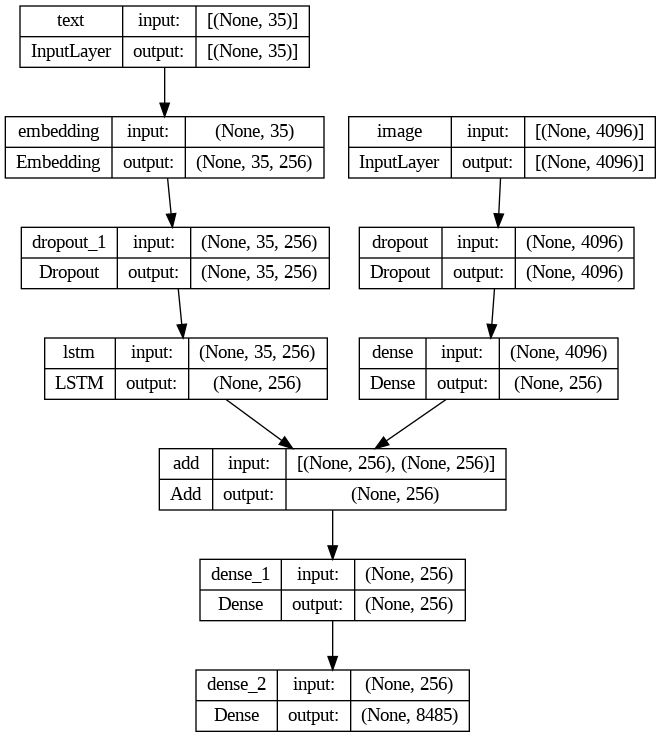

In [ ]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

encoder_decoder_model = Model(inputs=[inputs1, inputs2], outputs=outputs)
encoder_decoder_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# plot the model
plot_model(encoder_decoder_model, show_shapes=True)

In [ ]:
# train the model
epochs = 25
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, img_to_cap_mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    encoder_decoder_model.fit(generator, epochs=1, steps_per_epoch=steps)

227/227 [==============================] - 67s 297ms/step - loss: 2.0562 - accuracy: 0.4671


In [ ]:
# save the model
encoder_decoder_model.save('/content/drive/MyDrive/Colab Notebooks/models'+'/model1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
from tensorflow.keras.models import load_model

model_path = '/content/drive/MyDrive/Colab Notebooks/models/model1.h5'

# Load the model
encoder_decoder_model = load_model(model_path)

# **Generating captions**

In [26]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [27]:
# generate caption for an image
def predict_caption(model, image_feature, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image_feature, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

# **Actual vs predicted captions**

In [ ]:
list(img_to_cap_mapping.items())[:5]

[('1000268201_693b08cb0e',
  ['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
   'startseq girl going into wooden building endseq',
   'startseq little girl climbing into wooden playhouse endseq',
   'startseq little girl climbing the stairs to her playhouse endseq',
   'startseq little girl in pink dress going into wooden cabin endseq']),
 ('1001773457_577c3a7d70',
  ['startseq black dog and spotted dog are fighting endseq',
   'startseq black dog and tri-colored dog playing with each other on the road endseq',
   'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
   'startseq two dogs of different breeds looking at each other on the road endseq',
   'startseq two dogs on pavement moving toward each other endseq']),
 ('1002674143_1b742ab4b8',
  ['startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
   'startseq little girl is sitting in front of large 

In [ ]:
def actual_predicted(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join('/content/Images', image_name)
    image = Image.open(img_path)
    captions = img_to_cap_mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(encoder_decoder_model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq man in an orange hat starring at something endseq
startseq man wears an orange hat and glasses endseq
startseq man with gauges and glasses is wearing blitz hat endseq
startseq man with glasses is wearing beer can crocheted hat endseq
startseq the man with pierced ears is wearing glasses and an orange hat endseq
--------------------Predicted--------------------
startseq man in black shirt and gold gold sweatshirt is standing next to man in blitz hat endseq


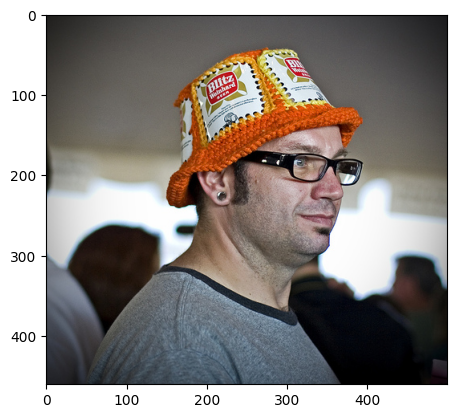

In [ ]:
actual_predicted('1007129816_e794419615.jpg')

---------------------Actual---------------------
startseq man lays on bench while his dog sits by him endseq
startseq man lays on the bench to which white dog is also tied endseq
startseq man sleeping on bench outside with white and black dog sitting next to him endseq
startseq shirtless man lies on park bench with his dog endseq
startseq man laying on bench holding leash of dog sitting on ground endseq
--------------------Predicted--------------------
startseq man lays on bench with his feet on his feet endseq


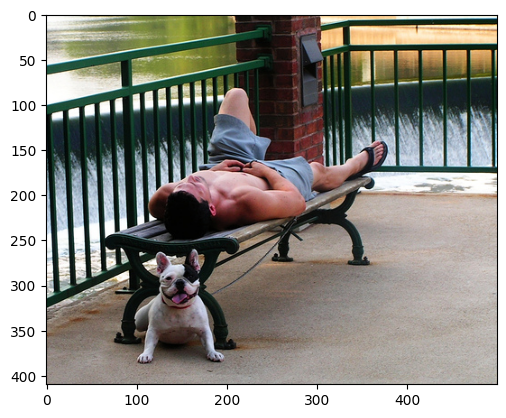

In [ ]:
actual_predicted('1003163366_44323f5815.jpg')

# **generating captions for image out of the traning dataset**

1/1 [==============================] - 1s 1s/step
startseq the yellow dog runs across the lawn endseq


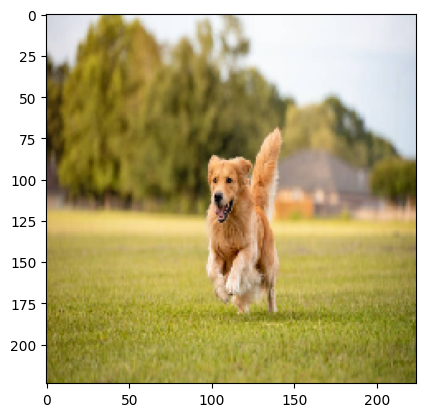

In [30]:
img_path = '/content/drive/MyDrive/Colab Notebooks/temp_img/istockphoto-1252455620-612x612.jpg'
img = load_img(img_path, target_size=(224, 224))
# convert image to numpy array
img_arr = img_to_array(img)
# reshape data for model
img1 = img_arr.reshape((1, img_arr.shape[0], img_arr.shape[1], img_arr.shape[2]))
# preprocess image for vgg16
img2 = preprocess_input(img1)
# extract features
f = vgg_model.predict(img2)

pred_cap = predict_caption(encoder_decoder_model, f, tokenizer, max_length)
print(pred_cap)
plt.imshow(img)